# Have LLM generate Uniprot SPARQL queries from natural language questions
In this notebook, we ask natural language questions of the Uniprot dataset, have a large-language model (LLM) generate a SPARQL query from the question, and run it against a graph database containing the Uniprot dataset.

The goal is to determine how well the LLM can generate the query. Is the correct query? Does it return expected results? If it does, we gain confidence in the ability to build a natural language question interface to our graph, enabling domain specialists to query the graph without having to know how to write SPARQL queries. 

## How we test it
As the figure below shows, when the user asks a question, we build a prompt for the LLM to generate a SPARQL query. We run that query against the graph database and remember the result for reporting.

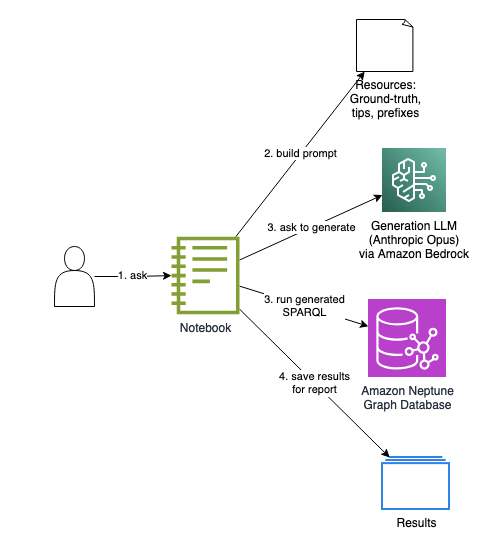

We use Amazon Neptune as an RDF graph database. It holds the Uniprot data. 

Our LLM is Anthropic Opus 3.x, which we access via Amazon Bedrock.

We have three files in the resources directory, which we use to build a prompt to the LLM.

1. ```ground-truth.yaml```. A set of ground truth Uniprot queries. We map a natural language question to the equivalent SPARQL query to run on the Uniprot dataset. This gives the LLM numerous examples how to write Uniprot SPARQL queries from natural language question. Here is an excerpt of that file:

```
question: Show me all transmembrane regions
  SPARQL: |
    SELECT  ?protein ?begin ?end
    WHERE
    {
      ?protein  rdf:type     up:Protein ;
                up:annotation  ?annotation .
      ?annotation  rdf:type  up:Transmembrane_Annotation .
      ?annotation up:range ?range .
      ?range faldo:begin ?begin .
      ?range faldo:end ?end .
    }
```

2. ```tips.yaml```. Further instructions for the LLM to follow when writing a SPARQL query for Uniprot. For example:

```
- 'The ec:number of an enzyme is indicated by rdfs:subClassOf'
```

3. ```prefixes.txt```. A list of Uniprot-related prefixes to use for Uniprot SPARQL queries. We ask the LLM to omit prefixes in generated SPARQL queries. We add these prefixes before submitting to graph database. 

We run four types of tests: 

- implicit_zero: The context for the LLM does not reference tips or ground truth examples. This is a zero-shot approach. We expect this to be the least successful test.
- implicit_tips: The context for the LLM includes tips but not ground truth examples.
- implicit_few: The context for the LLM includes ground truth examples but no tips. This is a few-shot approach. 
- implicit_few_tips: The context for the LLM includes ground truth examples plus tips. This is a few-shot approach. We expect this to be the most successful test.

We save results of these tests to folders having the names implicit_zero, implicit_tips, implicit_few, implicit_few_tips.

See README.md for instructions how to setup notebook, Neptune cluster, and Bedrock to run these examples.

## Define dependencies and functions

In [ ]:
!pip install -q jinja2==3.1.*

In [2]:
import os
import csv
import yaml
import json
import boto3
import utilities as u
import jinja2
from pathlib import Path
from typing import List, Union, Optional
from typing import Any as JsonType

from botocore.config import Config

# backoff for Bedrock calls via boto3
config = Config(
   retries = {
      'max_attempts': 5,
      'mode': 'standard'
   }
)

# Create bedrock client
session=boto3.Session()
bedrock_runtime = boto3.client(
    "bedrock-runtime", 
    region_name=u.AWS_REGION,
    config=config
)

jenv = jinja2.Environment(trim_blocks=True, lstrip_blocks=True)
model_id = "anthropic.claude-3-opus-20240229-v1:0"
temperature = 0.3
resources = Path.cwd() / "resources"

# load the prefixes, ground-truth examples, and tips
pfx = (Path.cwd() / "resources" / "prefixes.txt").read_text()
ground_truth = yaml.safe_load((resources / "ground-truth.yaml").read_text())
tips = yaml.safe_load((resources / "tips.yaml").read_text())


In [3]:
# resources/prompt.yaml is a template for our prompt
prompt_template_json = yaml.safe_load((resources / "prompt.yaml").read_text())

# function to plug values into the prompt.yaml template. uses jinja
def apply_jinja(json_blob: JsonType, **kwargs) -> JsonType:
    if isinstance(json_blob, str):
        return jenv.from_string(json_blob).render(
                        question=kwargs["question"],
                        tips=kwargs["tips"],
                        examples=kwargs["examples"])
    elif isinstance(json_blob, list):
        return [apply_jinja(x, **kwargs) for x in json_blob]
    elif isinstance(json_blob, dict):
        return {k: apply_jinja(v, **kwargs) for k, v in json_blob.items()}
    else:
        return json_blob

# generate LLM prompt by plugging in values for:
# 1. Tips. Leave blank if none.
# 2. Ground-truth/few-shot examples. Leave blank if none.
# 3. The natural language question.
def generate_prompt(prompt_template_json: JsonType,
                    tips: List[str],
                    question: str,
                    few_shot_examples: List[dict]) -> JsonType:
    prompt_json = apply_jinja(prompt_template_json, 
                               question=question,
                               tips=tips,
                               examples=few_shot_examples)
    return prompt_json
    
# Generate SPARQL query by plugging in values for:
# 1. Tips. Leave blank if none.
# 2. Ground-truth/few-shot examples. Leave blank if none.
# 3. The natural language question.
#
# This uses generate_prompt above to form the prompt. It then invokes LLM via Bedrock.
# From the response, it extracts generated SPARQL. 
def generate_sparql(prompt_template: JsonType,
                    tips: List[str],
                    question: str,
                    few_shot_examples: List[dict]) -> str:
    """
    Given a natural language question, use the LLM to transform that
    into a SPARQL query (using the prompt template) and return the query.
    """
    prompt = generate_prompt(prompt_template, tips, question, few_shot_examples)
    sys_prompt=prompt[0]['system']
    messages=prompt[1:]
    
    response = bedrock_runtime.invoke_model(
        modelId=model_id,
        body=json.dumps(
            {
                "anthropic_version": "bedrock-2023-05-31",
                "max_tokens": 1024,
                "temperature": temperature,
                "messages": messages,
                "system": sys_prompt
            }
        ),
    )
    result = json.loads(response.get("body").read())
    output_list = result.get("content", [])
    sparql = "".join(output["text"] for output in output_list if output["type"] == "text")
    
    # get inside the <sparql> tag
    try:
        idx = sparql.index("<sparql>")
        sparql = sparql[idx+8:]
    except ValueError:
        pass
    try:
        idx = sparql.index("</sparql>")
        sparql = sparql[:idx]
    except ValueError:
        pass

    return sparql

## Run tests

We run the four tests documented above.


In [1]:
import time

# Run one test where the question is the groud-truth example at the specified index.
# Use_tips and use_few are booleans. Set to control the type of test to run.
# Writes result to {folder_name}/{index}.json.
# If using few-shot, the examples provided are ALL BUT the example at index!!!
# That way, the LLM does not KNOW ABOUT the question at index but still benefits from the other examples.
def run_one_test(index, use_tips, use_few, folder_name):
    the_tips = tips if use_tips else []

    q=ground_truth[index]
    nlq=q['question']
    expected_sparql=q['SPARQL']
    error_msg=""
    gen_sparql=""
    res=None

    training_examples=[]
    if use_few:
        training_examples = ground_truth[:index] + ground_truth[index+1:] # all but!!
        assert q["SPARQL"] not in {x["SPARQL"] for x in training_examples}

    generated_sparql = generate_sparql(prompt_template_json, the_tips, nlq, training_examples)
            
    sparql=f"""
        {pfx}

        {generated_sparql}

        LIMIT 20
    """
            
    try:
        # run on Neptune
        res=u.execute_sparql(sparql, session) 
        if 'message' in res:
            error_msg=res['message'].replace("\n", " ")
        if not(folder_name is None):
            u.write_sparql_res(folder_name, str(index), nlq, expected_sparql, sparql, res, error_msg)
        else:
            print(nlq)
            print(sparql)
            print(res)

    except Exception as e:
        print(f"Error on {index}")
        print("Exception: {}".format(type(e).__name__))
        print("Exception message: {}".format(e))
        error_msg="Exception message: {}".format(e).replace("\n", " ")
        if not(folder_name is None):
            u.write_sparql_res(folder_name, str(index), nlq, q['SPARQL'], sparql, [], error_msg)

# In our testing our account had a throttle limit on Bedrock runtime model invocation.
# Besides using boto3 for retries and backoff, we also introduced a sleep between calls.
# Set this to -1 if you do NOT wish to sleep.
SLEEP_INTERVAL_SECS=70

# Run all questions from ground-truth. 
# Use_tips and use_few are booleans. Set to control the type of test to run.
# Writes result to {folder_name}/{index}.json.
def run_tests(folder_name, use_tips, use_few):

    folder=f"./{folder_name}" 
    if not(os.path.exists(folder) and os.path.isdir(folder)):
        os.mkdir(folder)

    for index, q in enumerate(ground_truth):
        if SLEEP_INTERVAL_SECS > 0:
            time.sleep(SLEEP_INTERVAL_SECS)
        print(f"{folder_name} {str(index)}")
        run_one_test(index, use_tips, use_few, folder_name)

# Run your own query nlq. The LLM will generated a SPARQL query using few+tips approach. 
# SPARQL results are returned.
def run_yourown_query(nlq):
    training_examples = ground_truth
            
    generated_sparql = generate_sparql(prompt_template_json, tips, nlq, training_examples) 
    sparql=f"""
        {pfx}

        {generated_sparql}

        LIMIT 20
    """
            
    res=u.execute_sparql(sparql, session) 
    
    print(generated_sparql)
    print(res)



### Run the four types of tests

In [5]:
rm -rf implicit_zero implicit_tips implicit_few implicit_few_tips

In [ ]:
run_tests("implicit_zero", False, False)

run_tests("implicit_tips", True, False)

run_tests("implicit_few", False, True)

run_tests("implicit_few_tips", True, True)

In [7]:
u.make_report("implicit_zero")
u.make_report("implicit_tips")
u.make_report("implicit_few")
u.make_report("implicit_few_tips")

## One-off queries


In [ ]:
run_one_test(5, True, True, None)

In [ ]:
run_yourown_query("What protein is in frogs")